## Overview

This notebook demonstrates how to get started with using the OpenAI library and demonstrates how to leverage multimodal capabilities of Llama 3.2 models as Model-as-service (MaaS).

### Objective

- Configure OpenAI SDK for the Llama 3.2 Completions API
- Chat with Llama 3.2 models with different prompts and model parameters
- Build and use Llama 3.2 GenAI powered application for Car Damage Assessment.

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage


## Get started

### Install Vertex AI SDK for Python and other required packages


In [5]:
! pip3 install --upgrade --quiet google-cloud-aiplatform openai gradio

### Restart runtime (Colab only)

To use the newly installed packages, you must restart the runtime on Google Colab.

In [6]:
import sys

if "google.colab" in sys.modules:

    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

In [ ]:
import sys

if "google.colab" in sys.modules:

    from google.colab import auth

    auth.authenticate_user()

### Set Google Cloud project information

To get started using Vertex AI, you must have an existing Google Cloud project and [enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com). Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).

In [2]:
PROJECT_ID = "upheld-quanta-442214-i7"  # @param {type:"string"}

# Only `us-central1` is supported region for Llama 3.2 models using Model-as-a-Service (MaaS).
LOCATION = "us-central1"

### Create a Cloud Storage bucket

Create a storage bucket to store tutorial artifacts.

In [3]:
BUCKET_NAME = "cuhk_fashion_report_2024_image_batch1"  # @param {type:"string"}

BUCKET_URI = f"gs://{BUCKET_NAME}"

In [4]:
! gsutil mb -l {LOCATION} -p {PROJECT_ID} {BUCKET_URI}

Creating gs://cuhk_fashion_report_2024_image_batch1/...
ServiceException: 409 A Cloud Storage bucket named 'cuhk_fashion_report_2024_image_batch1' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


### Initialize Vertex AI SDK for Python

In [5]:
import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION, staging_bucket=BUCKET_URI)

### Import libraries

Import libraries to use in this tutorial.

In [6]:
import json
import re
import uuid
from io import BytesIO

import gradio as gr
import matplotlib.pyplot as plt
# Chat completions API
import openai
from google.auth import default, transport
from google.cloud import storage
from PIL import Image

In [7]:
def visualize_image_from_bucket(bucket_name: str, blob_name: str) -> None:
    """Visualizes an image stored in a Google Cloud Storage bucket."""
    try:
        # Create a client for interacting with Google Cloud Storage
        storage_client = storage.Client()

        # Get a reference to the bucket and blob
        bucket = storage_client.bucket(bucket_name)
        blob = bucket.blob(blob_name)

        # Download the image data into memory
        image_data = blob.download_as_bytes()

        # Open the image using PIL
        image = Image.open(BytesIO(image_data))

        # Display the image using matplotlib
        plt.figure(figsize=(10, 10))  # Set the figure size (adjust as needed)
        plt.imshow(image)
        plt.axis("off")  # Turn off axis labels
        plt.show()

    except Exception as e:
        print(f"Error visualizing image: {e}")

### Configure OpenAI SDK for the Llama 3.2 Chat Completions API

To configure the OpenAI SDK for the Llama 3.2 Chat Completions API, you need to request the access token and initialize the client pointing to the Llama 3.2 endpoint.


#### Authentication



In [8]:
credentials, _ = default()
auth_request = transport.requests.Request()
credentials.refresh(auth_request)

Then configure the OpenAI SDK to point to the Llama 3.2 Chat Completions API endpoint.

Notice, only `us-central1` is supported region for Llama 3.2 models using Model-as-a-Service (MaaS).

In [9]:
MODEL_LOCATION = "us-central1"
MAAS_ENDPOINT = f"{MODEL_LOCATION}-aiplatform.googleapis.com"

client = openai.OpenAI(
    base_url=f"https://{MAAS_ENDPOINT}/v1beta1/projects/{PROJECT_ID}/locations/{LOCATION}/endpoints/openapi",
    api_key=credentials.token,
)

#### Llama 3.2 models

You can experiment with various supported Llama 3.2 models.

This tutorial use Llama 3.2 90B Vision Instruct using Model-as-a-Service (MaaS). Using Model-as-a-Service (MaaS), you can access Llama 3.2 models in just a few clicks without any setup or infrastructure hassles.

You can also access Llama models for self-service in Vertex AI Model Garden, allowing you to choose your preferred infrastructure. [Check out Llama 3.2 model card](https://console.cloud.google.com/vertex-ai/publishers/meta/model-garden/llama3-2?_ga=2.31261500.2048242469.1721714335-1107467625.1721655511) to learn how to deploy a Llama 3.2 models on Vertex AI.

In [17]:
MODEL_ID = "meta/llama-3.2-90b-vision-instruct-maas"  # @param {type:"string"} ["meta/llama-3.2-90b-vision-instruct-maas"]

### Chat with Llama 3.2

Use the Chat Completions API to send a multi-model request to the Llama 3.2 model.

#### Hello, Llama 3.2 90B  Yeah!

In [13]:
prompt = """
Background:
I am conducting a data science master's project focused on analyzing 10,000 fashion images to extract detailed attributes for each item. Your task is to meticulously analyze each image and identify specific attributes from the provided categories. The output must adhere strictly to the JSON format illustrated in the example below. Ensure high accuracy and consistency in your classifications to facilitate downstream data analysis.

________________________________________
Instructions:
1. Category Selection:
   For each fashion item image, identify and classify attributes based on the following categories. Each category is uniquely numbered and precisely defined to ensure comprehensive and granular data collection.

   • **Category 0: Fashion Main Category**
       - **Description:** Broad primary categories encompassing all types of fashion items.
       - **Examples:** Clothing, Footwear, Accessories, Outerwear, Bags, Jewelry, Hats.

   • **Category 1: Fashion Item Sub Category**
       - **Description:** Specific subcategories under each main category for precise classification.
       - **Examples:** Blazer, Jeans, T-Shirt, Sneakers, Handbag, Necklace, Fedora.

   • **Category 2: Patterns**
       - **Description:** The arrangement of forms, lines, or shapes on the surface of the fashion item, contributing to its aesthetic appeal.
       - **Examples:** Stripes, Polka Dots, Chevron, Houndstooth, Paisley, Geometric, Abstract, None.

   • **Category 3: Prints**
       - **Description:** Repeated decorative designs or motifs applied to the fabric or surface of the fashion item.
       - **Examples:** Floral Print, Animal Print, Camouflage Print, Graphic Prints, Artistic Prints, Tie-Dye, Digital Prints, None.

   • **Category 4: Graphics**
       - **Description:** Illustrations, logos, text, or other visual elements that are part of the fashion item's design.
       - **Examples:** Logo Embroidery, Graphic Tees, Statement Text, Brand Symbols, Decorative Illustrations, Minimalist Graphics, None.

   • **Category 5: Materials, Fabrics, and Finishes**
       - **Description:** Specifies the materials, fabric compositions, and finishes used in the item.
       - **Examples:** 100% Merino Wool, Modal Fiber Blend, Recycled Polyester, Brushed Chenille, Organic Cotton, Denim, Leather, Satin.

   • **Category 6: Fit**
       - **Description:** Describes how the clothing item fits the body, indicating the intended silhouette.
       - **Examples:** Fitted, Relaxed, Oversized, Tailored, Slim, Regular, Loose.

   • **Category 7: Silhouette**
       - **Description:** Refers to the overall shape or outline of the garment, contributing to its style and appearance.
       - **Examples:** Slim, Boxy, A-line, Straight, Flared, Peplum, Structured.

   • **Category 8: Length**
       - **Description:** Indicates the length of the clothing item, providing information on its coverage.
       - **Examples:** Mini, Knee-length, Midi, Ankle, Maxi, Cropped, Floor-length.

   • **Category 9: Design Features**
       - **Description:** Highlights specific design elements and structural features of the garment.
       - **Examples:** Double-breasted, Notched Collar, Asymmetric Hem, Patch Pockets, Zipper Closures, Embroidery, Sequins, Ruffles, Buttons, Belted Waist.

   • **Category 10: Embellishments**
       - **Description:** Details any additional decorative elements that enhance the item's aesthetic.
       - **Examples:** Embroidery, Sequins, Patches, Appliqués, Beading, Rhinestones, Lace.

   • **Category 11: Style**
       - **Description:** Refers to the distinctive appearance or design characteristic of the fashion item, aligned with specific fashion movements or personal aesthetics.
       - **Examples:** Classic, Minimalist, Bohemian, Streetwear, High-Fashion, Eclectic, Sporty, Preppy.

   • **Category 12: Theme**
       - **Description:** The underlying subject or motif that gives direction to the design of the fashion item.
       - **Examples:** Nautical, Military, Vintage, Futuristic, Tropical, Gothic, Romantic, Urban.

   • **Category 13: Overall Inspiration**
       - **Description:** The primary influence or source of creativity behind the fashion item's design, reflecting cultural, artistic, or temporal inspirations.
       - **Examples:** Audrey Hepburn-inspired, Americana, Retro, Avant-garde, Sustainable, Eclectic, Bohemian, Futuristic.

   • **Category 14: Main Color**
       - **Description:** The dominant color of the fashion item, serving as the primary visual identifier.
       - **Examples:** White, Black, Red, Blue, Green, Yellow, Pink, Purple, Neutral Tones, Pastels, Metallics, Pantone 11-0602 TCX (White), Pantone 14-0852 TCX (Spectra Yellow).

   • **Category 15: Sub Color**
       - **Description:** Secondary or accent colors present in the item that complement or contrast with the main color.
       - **Examples:** Off-white, Cream, Light Beige, Ivory, Neon Green, Metallic Silver, Navy Blue, Dusty Rose, Burnt Orange, Sky Blue, Teal, Burgundy.

   • **Category 16: Usage Categories**
       - **Description:** Contexts or occasions for which the item is intended, indicating its suitability for specific events or activities.
       - **Examples:** Formal Wear, Casual, Business Casual, Athletic, Evening Wear, Streetwear, Resort Wear, Wedding, Office, Party, Travel, Outdoor, Beachwear.

   • **Category 17: Gender-Based Categories**
       - **Description:** Specifies the intended gender for the fashion item, reflecting design and sizing considerations.
       - **Examples:** Male, Female, Non-binary, Gender Fluid, Unisex, Androgynous.

   • **Category 18: Seasonality**
       - **Description:** Specifies the season(s) the item is designed for, indicating appropriate materials and designs for weather conditions.
       - **Examples:** Spring, Summer, Fall, Winter, All-Season, Transitional.

   • **Category 19: Embellishments and Accessories**
       - **Description:** Details any additional decorative elements or attached accessories that enhance functionality or style.
       - **Examples:** Belts, Hoods, Scarves, Patches, Appliqués, Buckles, Chains, Pompoms.

   • **Category 20: Closure Type**
       - **Description:** Describes how the garment is fastened, affecting both functionality and style.
       - **Examples:** Buttons, Zipper, Hook and Loop, Tie, Snap, Buckle, Magnetic Closures, Velcro.

   • **Category 21: Target Age Group**
       - **Description:** Specifies the intended age demographic for the fashion item, guiding design and marketing strategies.
       - **Examples:** Teens (13-19), Young Adults (20-30), Adults (31-50), Seniors (51+), Children (Under 13), All Ages, Toddlers (1-3).

   • **Category 22: Popularity and Sales Status**
       - **Description:** Indicates whether the fashion item is currently popular or a hot-selling item in 2023, reflecting market trends and consumer demand.
       - **Examples:**
           - **Highly Popular:** Widely recognized and sought after, frequently featured in fashion media.
           - **Trending:** Gaining popularity rapidly, often seen in influencer posts and social media platforms.
           - **Moderately Popular:** Known within certain demographics or regions, maintaining steady sales.
           - **Not Popular:** Limited recognition and low sales figures.
           - **Unknown:** Popularity cannot be determined from the available information.

2. Attention to Detail:
   - Examine every aspect of the fashion item, ensuring that no attribute is overlooked.
   - Consider elements such as stitching, texture, embellishment placement, and unique design aspects that may not be immediately apparent.
   - If an attribute spans multiple categories (e.g., a patterned fabric with a specific closure type), ensure each category is accurately populated.

3. Consistency and Accuracy:
   - Maintain uniformity in category responses to facilitate reliable data aggregation.
   - Avoid ambiguous or subjective terms; choose the most precise term from the provided examples.
   - In cases where multiple applicable examples exist, prioritize based on prominence and visibility in the image.

4. Handling Uncertainty:
   - If an attribute is not discernible from the image, default to "Unknown" rather than "N/A" unless **Category 0** explicitly dictates otherwise.
   - Ensure that "Unknown" is used judiciously to reflect genuine uncertainty without compromising data integrity.

#### 2. Output Format:
• Your response should be **only** a JSON object covering Categories 0 to 22.
• If **Category 0** is selected as "Other", "Not Applicable", or "N/A", set all Categories 1 to 22 to "N/A".
• Follow the JSON example below **precisely**. Do **not** include any additional text or explanations beyond the JSON structure.

#### 3. JSON Example:
```json
{
  "Category 0: Fashion Main Category": "Clothing",
  "Category 1: Fashion Item Sub Category": "Blazer",
  "Category 2: Patterns": "Stripes",
  "Category 3: Prints": "Graphic Prints",
  "Category 4: Graphics": "Logo Embroidery",
  "Category 5: Materials, Fabrics, and Finishes": "100% Merino Wool",
  "Category 6: Fit": "Fitted",
  "Category 7: Silhouette": "Tailored",
  "Category 8: Length": "Ankle-length",
  "Category 9: Design Features": "Double-breasted, Notched Collar, Asymmetric Hem",
  "Category 10: Embellishments": "Sequins",
  "Category 11: Style": "Classic",
  "Category 12: Theme": "Americana",
  "Category 13: Overall Inspiration": "Audrey Hepburn-inspired",
  "Category 14: Main Color": "White, Pantone 11-0602 TCX",
  "Category 15: Sub Color": "Off-white, Cream",
  "Category 16: Usage Categories": "Formal Wear",
  "Category 17: Gender-Based Categories": "Unisex",
  "Category 18: Seasonality": "Winter",
  "Category 19: Embellishments and Accessories": "None",
  "Category 20: Closure Type": "Buttons",
  "Category 21: Target Age Group": "Young Adults (20-30)",
  "Category 22: Popularity and Sales Status": "Trending"
}
"""

In [14]:
max_tokens = 4096

response = client.chat.completions.create(
    model=MODEL_ID,
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "image_url": {
                        "url": "gs://cuhk_fashion_report_2024_image_batch1/image2_section_4.jpg"
                    },
                    "type": "image_url",
                },
                {"text": prompt, "type": "text"},
            ],
        },
    ],
    temperature=1.0,
    max_tokens=max_tokens,
    top_p=1.0
)

print(response.choices[0].message.content)

**Answer:**

*Answer*: 
```json
{
  "Category 0: Fashion Main Category": "Clothing",
  "Category 1: Fashion Item Sub Category": "JT Womens Long Sleeve Double Breasted Blazer in Cream",
  "Category 2: Patterns": "None",
  "Category 3: Prints": "None",
  "Category 4: Graphics": "None",
  "Category 5: Materials, Fabrics, and Finishes ": "Wool",
  "Category 6: Fit": "Regular",
  "Category 7: Silhouette": "Tailored",
  "Category 8: Length": "Midi",
  "Category 9: Design Features": "Double-breasted, Notched collar, Belted",
  "Category 10: Embellishments": "None",
  "Category 11: Style": "Classic",
  "Category 12: Theme": "Americana",
  "Category 13: Overall Inspiration": "Audrey Hepburn-inspired",
  "Category 14: Main Color": "Cream",
  "Category 15: Sub Color": "None",
  "Category 16: Usage Categories": "Formal Wear",
  "Category 17: Gender-Based Categories": "Female",
  "Category 18: Seasonality": "Winter",
  "Category 19: Embellishments and Accessories": "Belt",
  "Category 20: Closure T

You get the response as shown below.

You use the helper function to visualize the image.

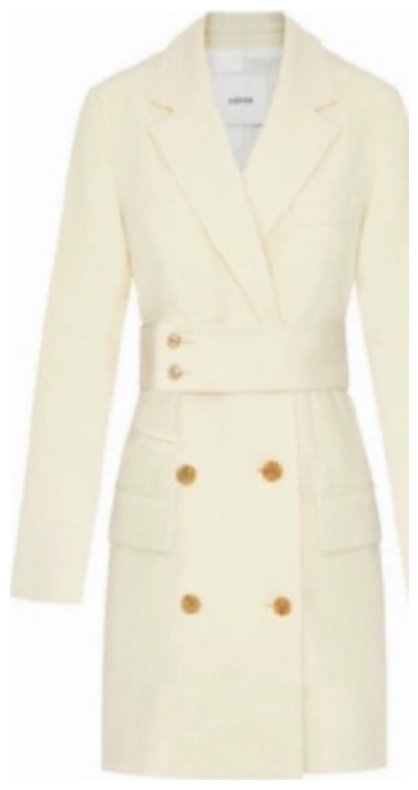

In [49]:
visualize_image_from_bucket("cuhk_fashion_report_2024_image_batch1", "image2_section_4.jpg")

In [24]:
# =====================================
# 2. Import Required Libraries
# =====================================

import os
import json
import pandas as pd
from google.colab import drive
from google.cloud import storage
from google.oauth2 import service_account
import time


# =====================================
# 5. Define Constants and Initialize DataFrame
# =====================================

# GCS bucket details
BUCKET_NAME = 'cuhk_fashion_report_2024_image_batch1'
PREFIX = ''  # If your images are in a subfolder, specify the prefix

# Path to save the Excel file in Google Drive
EXCEL_FILE_PATH = '/content/drive/MyDrive/fashion_report_2024_results.xlsx'

# Define the categories (Category 0 to Category 22)
num_categories = 23
category_names = [f"Category {i}" for i in range(num_categories)]

# Additional columns for image path and image name
additional_columns = ['image_path', 'image_name']

# Complete list of columns
all_columns = additional_columns + category_names

# Delete the original Excel file if it exists
if os.path.exists(EXCEL_FILE_PATH):
    os.remove(EXCEL_FILE_PATH)
    print(f"Deleted existing Excel file at {EXCEL_FILE_PATH}")

# Initialize the DataFrame with image_path, image_name, and categories
df = pd.DataFrame(columns=all_columns)
print("Initialized new DataFrame with 'image_path' and 'image_name' columns.")

# =====================================
# 6. Define the API Call Function
# =====================================

# Placeholder function for the Llama API call
def call_llama_api(image_url, prompt, max_tokens=4096, temperature=1.0, top_p=1.0):
    """
    Calls the Llama API with the given image URL and prompt.

    Args:
        image_url (str): The GCS URL of the image.
        prompt (str): The prompt to send along with the image.
        max_tokens (int): Maximum tokens in the response.
        temperature (float): Sampling temperature.
        top_p (float): Nucleus sampling parameter.

    Returns:
        response (dict): The API response.
    """
    # Example using OpenAI's API (modify according to your API)
    # response = openai.ChatCompletion.create(
    #     model="gpt-3.5-turbo",
    #     messages=[
    #         {
    #             "role": "user",
    #             "content": f"![image]({image_url})\n{prompt}"
    #         }
    #     ],
    #     temperature=temperature,
    #     max_tokens=max_tokens,
    #     top_p=top_p
    # )
    # return response

    # TODO: Replace the following mock response with your actual API call
    mock_response = {
        "choices": [
            {
                "message": {
                    "content": json.dumps({
                        "Category 0: Fashion Main Category": "Clothing",
                        "Category 1: Fashion Item Sub Category": "JT Womens Long Sleeve Double Breasted Blazer in Cream",
                        "Category 2: Patterns": "None",
                        "Category 3: Prints": "None",
                        "Category 4: Graphics": "None",
                        "Category 5: Materials, Fabrics, and Finishes ": "Wool",
                        "Category 6: Fit": "Regular",
                        "Category 7: Silhouette": "Tailored",
                        "Category 8: Length": "Midi",
                        "Category 9: Design Features": "Double-breasted, Notched collar, Belted",
                        "Category 10: Embellishments": "None",
                        "Category 11: Style": "Classic",
                        "Category 12: Theme": "Americana",
                        "Category 13: Overall Inspiration": "Audrey Hepburn-inspired",
                        "Category 14: Main Color": "Cream",
                        "Category 15: Sub Color": "None",
                        "Category 16: Usage Categories": "Formal Wear",
                        "Category 17: Gender-Based Categories": "Female",
                        "Category 18: Seasonality": "Winter",
                        "Category 19: Embellishments and Accessories": "Belt",
                        "Category 20: Closure Type": "Buttons",
                        "Category 21: Target Age Group": "Young Adults (20-30)",
                        "Category 22: Popularity and Sales Status": "Moderately Popular"
                    }, indent=4)
                }
            }
        ]
    }
    return mock_response

# =====================================
# 7. Define Function to Parse API Response
# =====================================

def parse_response(response_content):
    """
    Parses the JSON response content and extracts category values.

    Args:
        response_content (str): The JSON string from the API response.

    Returns:
        parsed_data (list): List of category values from Category 0 to Category 22.
    """
    try:
        data = json.loads(response_content)
        parsed_data = []
        for i in range(num_categories):
            # Find the key that starts with 'Category i:'
            category_key = next((k for k in data.keys() if k.startswith(f"Category {i}:")), None)
            if category_key:
                value = data.get(category_key, "N/A")
            else:
                value = "N/A"
            parsed_data.append(value)
        return parsed_data
    except json.JSONDecodeError:
        print("Failed to decode JSON response.")
        return ["N/A"] * num_categories

# =====================================
# 8. Define Function to Check All Categories N/A
# =====================================

def all_na(parsed_data):
    """
    Checks if all category values are 'N/A'.

    Args:
        parsed_data (list): List of category values.

    Returns:
        bool: True if all categories are 'N/A', False otherwise.
    """
    return all(value.strip().upper() == "N/A" for value in parsed_data)

# =====================================
# 9. List All Images in the GCS Bucket
# =====================================

def list_gcs_images(bucket_name, prefix=''):
    """
    Lists all image files in the specified GCS bucket and prefix.

    Args:
        bucket_name (str): The name of the GCS bucket.
        prefix (str): The prefix path in the bucket.

    Returns:
        image_urls (list): List of GCS URLs for image files.
    """
    bucket = storage_client.bucket(bucket_name)
    blobs = bucket.list_blobs(prefix=prefix)
    image_extensions = ('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff', '.webp')
    image_urls = [f"gs://{bucket_name}/{blob.name}" for blob in blobs if blob.name.lower().endswith(image_extensions)]
    return image_urls

# =====================================
# 10. Main Processing Loop
# =====================================

# Define your prompt here
prompt = "Please classify the fashion item in the image based on the provided categories."

# List all image URLs in the GCS bucket
image_urls = list_gcs_images(BUCKET_NAME, PREFIX)
total_images = len(image_urls)
print(f"Total images found: {total_images}")

# Iterate through each image
for idx, image_url in enumerate(image_urls, 1):
    print(f"\nProcessing image {idx}/{total_images}: {image_url}")
    retries = 0
    max_retries = 3
    success = False

    while retries < max_retries and not success:
        try:
            # Call the API
            response = call_llama_api(image_url, prompt)
            response_content = response['choices'][0]['message']['content']

            # Parse the response
            parsed_data = parse_response(response_content)

            # Check if all categories are 'N/A'
            if all_na(parsed_data):
                retries += 1
                print(f"All categories returned as 'N/A'. Retry {retries}/{max_retries} after delay.")
                time.sleep(5)  # Wait before retrying
            else:
                success = True
        except Exception as e:
            retries += 1
            print(f"Error during API call: {e}. Retry {retries}/{max_retries} after delay.")
            time.sleep(5)

    if not success:
        print(f"Failed to process image after {max_retries} retries. Appending 'N/A' for all categories.")
        parsed_data = ["N/A"] * num_categories

    # Extract image path and image name
    image_path = os.path.dirname(image_url) + '/'
    image_name = os.path.basename(image_url)

    # Create a dictionary for the new row, including image_path and image_name
    row_dict = {'image_path': image_path, 'image_name': image_name}
    row_dict.update({category_names[i]: parsed_data[i] for i in range(num_categories)})

    # Convert the row dictionary to a DataFrame
    new_row = pd.DataFrame([row_dict])

    # Concatenate the new row to the existing DataFrame
    df = pd.concat([df, new_row], ignore_index=True)

    # Save the updated DataFrame to Excel
    df.to_excel(EXCEL_FILE_PATH, index=False)
    print(f"Saved results to {EXCEL_FILE_PATH}")

    # Optional: Introduce a short delay to respect API rate limits
    time.sleep(1)

print("\nProcessing completed.")

Initialized new DataFrame with 'image_path' and 'image_name' columns.
Total images found: 2

Processing image 1/2: gs://cuhk_fashion_report_2024_image_batch1/image2_section_4.jpg
Saved results to /content/drive/MyDrive/fashion_report_2024_results.xlsx

Processing image 2/2: gs://cuhk_fashion_report_2024_image_batch1/image2_section_5.jpg
Saved results to /content/drive/MyDrive/fashion_report_2024_results.xlsx

Processing completed.


#### Use Llama 3.2 with different multimodal tasks

In this section, you will use Llama 3.2 to perform different multimodal tasks including image captioning and Visual Question Answering (VQA).

For each task, you'll define a different prompt and submit a request to the model as you did before.

In [ ]:
visualize_image_from_bucket("github-repo", "img/gemini/intro/landmark3.jpg")

##### Image captioning

In [ ]:
prompt = "Imagine you're telling a friend about this photo. What would you say?"

In [ ]:
response = client.chat.completions.create(
    model=MODEL_ID,
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "image_url": {
                        "url": "gs://github-repo/img/gemini/intro/landmark3.jpg"
                    },
                    "type": "image_url",
                },
                {"text": prompt, "type": "text"},
            ],
        },
    ],
    max_tokens=max_tokens,
)

In [ ]:
print(response.choices[0].message.content)

##### Visual Question Answering (VQA)

In [ ]:
prompt = """
Analyze this image and answer the following questions:
- What is the primary color in the image?
- What is the overall mood or atmosphere conveyed in the scene?
- Based on the visual clues, who might have taken the picture?"
"""

In [ ]:
response = client.chat.completions.create(
    model=MODEL_ID,
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "image_url": {
                        "url": "gs://github-repo/img/gemini/intro/landmark3.jpg"
                    },
                    "type": "image_url",
                },
                {"text": prompt, "type": "text"},
            ],
        },
    ],
    max_tokens=max_tokens,
)

In [ ]:
print(response.choices[0].message.content)